# Assignment No 2c
#### Assignment Credit 
###### *Dr. Sibt ul Hussain*


Text Classification (Sentiment Analysis) Using Bayes Rule 
==============


## Goal

Your goal in this part of assigment is to implement a Naive Bayes Multinomial classifier using  bag of words model for the classification of text (movie reviews) into different categories..

**Note** Please note that you are allowed to use only those libraries which we have discussed in the class, i.e. numpy, scipy, pandas.

Once you have build and test the model on the provided dataset. You will use the learned techniques to compete in a [Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial) competition and report your final score and leaderboard ranking to get full credit.

For final submission attach the screen-shot of the leader-board with your score.

## Submission Instructions
You are required to submit the original notebook file on the Slate (with .ipynb extension), with complete set of outputs. Students failing to do so will get zero marks. 

*Please read each step carefully and understand it fully before proceeding with code writing*

## Plagiarism
Any form of plagiarism will not be tolerated and result in 0 marks.


In [31]:
%pylab inline
import scipy.stats
import pandas as pd
import tools as t
from collections import defaultdict, Counter
import time
from PIL import Image

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/muhammad/anaconda3/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [32]:
import re

def parse_string(string): 
    """"
        Parse the input string and tokenize it using regular expressisons:
        First clean the string such that it does not have any punctuation or number, it must only have a-z and A-Z.
        Please note that while doing this, the spaces much not get disturbed, but in case of multiple spaces convert 
        them to one space.
        Then convert the string to lower case and return its words as a list of strings.
        
        Example:
        --------
        Input :  computer scien_tist-s are,,,  the  rock__stars of tomorrow_ <cool>  ????
        Output:  ['computer', 'scientists', 'are', 'the', 'rockstars', 'of', 'tomorrow']
        
        Parameters:
        ----------
        string: string to be parsed...
        re: regular expression to be used for the tokenization.
        
        Returns:
        ---------
        list of tokens extracted from the string...
    """
    
    # YOUR CODE HERE
    # Removing tags < >
    no_tags = re.sub(r'<[^>]+>', '', string)
    
    # Removing punctuation and numbers, keep spaces
    cleaned_string = re.sub(r'[^a-zA-Z\s]', '', no_tags)
    
    # Normalizing whitespace (replace multiple spaces with one)
    cleaned_string = re.sub(r'\s+', ' ', cleaned_string)
    
    # Converting to lowercase
    cleaned_string = cleaned_string.lower()
    
    # Spliting into words and return as a list
    return cleaned_string.strip().split()

In [33]:
def parse_file(filename): 
    """"
    Parameters:
    ----------
    filename: name of text file to be read
    
    Returns:
    ---------
    read file as string (decoded if necessary)
    """
    # Open file in text mode (not binary) and ensure correct encoding
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

In [34]:
def files_to_strings(X):
    
    """
        Read an array (or list) of files where each file content is read in a string...
        Input:
        -------
        X an array (or list) of file names
        
        Returns:
        --------
        X as a numpy array with each row containing a read string from the file...
    """
    
    # YOUR CODE HERE
    x = []
    for i in range(len(X)):
        x.append(parse_file(X[i]))
    X = np.array(x)
    
    return X

In [35]:
from nose.tools import assert_equal, assert_list_equal

assert_list_equal(parse_string("computer scien_tist-s are,,,  the  rock__stars of tomorrow_ <cool>  ????"),
        [u'computer', u'scientists', u'are', u'the', u'rockstars', u'of', u'tomorrow'], "Incorrect cleanning")


strings = files_to_strings(np.array(["./data/imdb1/neg/cv000_29416.txt", "./data/imdb1/pos/cv000_29590.txt"]))
with open("./data/imdb1/neg/cv000_29416.txt") as f:
    text = f.read()

assert_equal(strings[0], text, "At first index should be text of first file")
assert_equal(strings.shape, (2,), "Shape must be (2,) for two files in list")

In [36]:
def create_bow_dict(token_list):
    """
    Creates a Bag of Words using a dictionary for each document.
    
    Parameters:
    -----------
    tokens: list of tokens (documents)
    
    Returns:
    --------
    Dictionary which represents the word counts of a document
    """

    word_count = {}
    for token in token_list:
        if token in word_count:
            word_count[token] += 1
        else:
            word_count[token] = 1

    return word_count

In [43]:
def Remove_stopwords(Tokens):
    """
    Removes stopwords from a list of tokens.
    
    Parameters:
    -----------
    Tokens: list
        A list of words (tokens) from a single document.
        
    Returns:
    --------
    filtered_tokens: list
        A list with stopwords removed.
    """
    stopwords = ['is', 'a', 'for', 'the', 'of', 'in', 'and', 'to', 'an']
    filtered_tokens = [word for word in Tokens if word not in stopwords]
    return filtered_tokens

## Class Without removing Stopwords

In [20]:
# YOUR CODE HERE
        
## Hint, you can use python dictionary or default dict for counting the words
# or counter class from collections 

#TODO Complete this class for running the complete classifier... 

#You might need to define auxiliary classes for the complete algorithm.


class NaiveBayes:
    ''' Implements the Naive Bayes For Text Classification '''
    
    def __init__(self, classes):
        self.classes = classes
        self.class_word_counts = defaultdict(Counter)  # Store word counts for each class
        self.class_counts = defaultdict(int)  # Store example counts per class
        self.vocab = set()  # Store all unique words across the dataset
        self.class_priors = defaultdict(float)  # Store prior probabilities for each class
        
    def addExample(self, x, y):
        '''
        Add example to the corresponding class model.
        Input:
        ---------
        x: example (list of words)
        y: label (class label)
        '''
        # Update word counts and total examples for the class
        self.class_word_counts[y].update(x)
        self.class_counts[y] += 1
        self.vocab.update(x)
    
    def train(self, X, Y):
        ''' 
        Train the Naive Bayes model using the given data matrix X and labels Y.
        
        Input:
        ------
        X: [m x d] a data matrix of m d-dimensional examples.
        Y: [m x 1] a label vector.
        
        Returns:
        -----------
        Nothing
        '''
        # Process each example and its corresponding label
        for x, y in zip(X, Y):
            words = x[0].split()  # Split the document into words
            self.addExample(words, y)
        
        total_examples = len(Y)
        
        # Calculate prior probabilities for each class
        for c in self.classes:
            self.class_priors[c] = self.class_counts[c] / total_examples
        
    def test(self, X):
        ''' 
        Test the trained classifier on the given set of examples.
        
        Input:
        ------
        X: [m x d] a data matrix of m d-dimensional test examples.
        
        Returns:
        -----------
        pclass: the predicted class for each example.
        '''
        pclasses = []
        
        # Process each example
        for x in X:
            words = x[0].split()  # Split the test example into words
            predicted_class = self.predict(words)
            pclasses.append(predicted_class)
        
        return np.array(pclasses)
    
    def predict(self, x):
        '''
        Predict the label of a given input example.
        
        Input:
        ---------
        x: example (list of words)
        
        Returns:
        ---------
        predicted_class: The class with the highest score.
        '''
        class_scores = {}
        total_vocab_size = len(self.vocab)
        
        # Compute the log likelihood for each class
        for c in self.classes:
            # Start with the log prior probability of the class
            class_scores[c] = np.log(self.class_priors[c])
            
            # Calculate the log-likelihood for each word in the example
            word_count = self.class_word_counts[c]
            total_words_in_class = sum(list(word_count.values()))  # Total words in this class
            
            # Compute log-likelihood with Laplace smoothing
            for word in x:
                word_likelihood = (word_count[word] + 1) / (total_words_in_class + total_vocab_size)
                class_scores[c] += np.log(word_likelihood)
        
        # Return the class with the highest log probability
        return max(class_scores, key=class_scores.get)


## Class With removing stopwords

In [44]:
class NaiveBayes:
    ''' Implements the Naive Bayes For Text Classification '''
    
    def __init__(self, classes):
        self.classes = classes
        self.class_word_counts = defaultdict(Counter)  # Store word counts for each class
        self.class_counts = defaultdict(int)  # Store example counts per class
        self.vocab = set()  # Store all unique words across the dataset
        self.class_priors = defaultdict(float)  # Store prior probabilities for each class
        
    def addExample(self, x, y):
        '''
        Add example to the corresponding class model.
        Input:
        ---------
        x: example (list of words)
        y: label (class label)
        '''
        # Remove stopwords from the example
        filtered_words = Remove_stopwords(x)
        
        # Update word counts and total examples for the class
        self.class_word_counts[y].update(filtered_words)
        self.class_counts[y] += 1
        self.vocab.update(filtered_words)
    
    def train(self, X, Y):
        ''' 
        Train the Naive Bayes model using the given data matrix X and labels Y.
        
        Input:
        ------
        X: [m x d] a data matrix of m d-dimensional examples.
        Y: [m x 1] a label vector.
        
        Returns:
        -----------
        Nothing
        '''
        # Process each example and its corresponding label
        for x, y in zip(X, Y):
            words = x[0].split()  # Split the document into words
            self.addExample(words, y)
        
        total_examples = len(Y)
        
        # Calculate prior probabilities for each class
        for c in self.classes:
            self.class_priors[c] = self.class_counts[c] / total_examples
        
    def test(self, X):
        ''' 
        Test the trained classifier on the given set of examples.
        
        Input:
        ------
        X: [m x d] a data matrix of m d-dimensional test examples.
        
        Returns:
        -----------
        pclass: the predicted class for each example.
        '''
        pclasses = []
        
        # Process each example
        for x in X:
            words = x[0].split()  # Split the test example into words
            predicted_class = self.predict(words)
            pclasses.append(predicted_class)
        
        return np.array(pclasses)
    
    def predict(self, x):
        '''
        Predict the label of a given input example.
        
        Input:
        ---------
        x: example (list of words)
        
        Returns:
        ---------
        predicted_class: The class with the highest score.
        '''
        class_scores = {}
        total_vocab_size = len(self.vocab)
        
        # Remove stopwords from the input example
        filtered_words = Remove_stopwords(x)
        
        # Compute the log likelihood for each class
        for c in self.classes:
            # Start with the log prior probability of the class
            class_scores[c] = np.log(self.class_priors[c])
            
            # Calculate the log-likelihood for each word in the example
            word_count = self.class_word_counts[c]
            total_words_in_class = sum(list(word_count.values()))  # Total words in this class
            
            # Compute log-likelihood with Laplace smoothing
            for word in filtered_words:
                word_likelihood = (word_count[word] + 1) / (total_words_in_class + total_vocab_size)
                class_scores[c] += np.log(word_likelihood)
        
        # Return the class with the highest log probability
        return max(class_scores, key=class_scores.get)

In [45]:
tdir= "./data/imdb1/" # training dir...
#load data, get list of files for each class...
posfiles=t.get_files(tdir+'/pos','*',withpath=True)
negfiles=t.get_files(tdir+'/neg','*',withpath=True)

In [46]:
#generate training and testing data...
plabels=['pos']*len(posfiles)
nlabels=['neg']*len(posfiles)
labels=np.concatenate((plabels,nlabels)) # concatenate the +ve and -ve labels
tX=np.concatenate((posfiles,negfiles))
print ("Training data Dimensions =", tX.shape," Training labels dimensions=", labels.shape)

Training data Dimensions = (2000,)  Training labels dimensions= (2000,)


In [47]:
X=files_to_strings(tX) # read files and convert each file into set of strings and return an numpy array
X = X.reshape((X.shape[0], 1))
#Split the data into two halves training and test set...
traindata,trainlabels,testdata,testlabels=t.split_data(X,labels)
#Find the classes to train
classes=np.unique(labels)
#Train

## Calling without Removing Stopwords

In [24]:
#Now build a Naive Bayes classifier and test it...
print ('[Info] training a classifier for following classes {}, {}'.format(classes[0],classes[1]))
nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
pclasses=nb.test(testdata)
acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
print ("[Info] Accuracy = {}".format(acc))

[Info] training a classifier for following classes neg, pos
[Info] Accuracy = 0.7833333333333333


## Calling with Removing Stopwords

In [48]:
#Now build a Naive Bayes classifier and test it...
print ('[Info] training a classifier for following classes {}, {}'.format(classes[0],classes[1]))
nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
pclasses=nb.test(testdata)
acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
print ("[Info] Accuracy = {}".format(acc))

[Info] training a classifier for following classes neg, pos
[Info] Accuracy = 0.805


### Test Cells Start
#### Do not Modify

In [49]:
from nose.tools import assert_in, assert_equal

nb = NaiveBayes(classes)
nb.train(traindata, trainlabels)
assert_equal(nb.test(testdata).shape[0], testdata.shape[0])
assert_in(type(nb.predict(["ok"])), [str, np.str_, str], "Predict should return a label not list or array")


In [50]:
from nose.tools import assert_greater

nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
pclasses=nb.test(testdata)
acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
assert_greater(acc, 0.77, "Acc must be greater then 77% you are doing something wrong")    

In [51]:
from nose.tools import assert_equal

comment_pos = "A nice movie, the case was good. Overall a perfect play"
comment_neg = "A waste of time, cast was bad. a clear No!"

#generate training and testing data...
tX=np.concatenate((posfiles,negfiles))
X=files_to_strings(tX)
X = X.reshape((X.shape[0], 1))

plabels=['pos']*len(posfiles)
nlabels=['neg']*len(posfiles)
true_labels = np.concatenate((plabels,nlabels))
inverted_labels = np.concatenate((nlabels,plabels))

true_nb=NaiveBayes(classes)
true_nb.train(X,true_labels)

inverted_nb=NaiveBayes(classes)
inverted_nb.train(X,inverted_labels)

assert_equal( true_nb.predict(comment_pos.split()), "pos" )
assert_equal( true_nb.predict(comment_neg.split()), "neg" )

assert_equal( inverted_nb.predict(comment_pos.split()), "neg" )
assert_equal( inverted_nb.predict(comment_neg.split()), "pos" )

### Test Cells End

# Cross Validation

Now lets throw our methods to winds of different folds and measure their accuracy...

In [52]:
#Now lets generate n-fold training and testing data...
nfolds=10
folds=t.generate_folds(X,labels,nfolds) # generate folds for 
for k in arange(len(folds)):
    print (folds[k][0].shape, folds[k][2].shape)

Generating CV data for 2 classes
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)
(1800, 1) (200, 1)


In [53]:
totacc=[]
#train a classifier for each fold...
classes=np.unique(labels)

for k in range(nfolds):
    nb=NaiveBayes(classes)
    
    traindata=folds[k][0]
    trainlabels=folds[k][1]
    
    #Lets first train the classifier
    nb.train(traindata,trainlabels)
    
    testdata=folds[k][2]
    testlabels=folds[k][3]
    
    #Lets test the classifier
    pclasses= nb.test(testdata)
    
    #print pclasses
    acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
    print ("[Info] Fold {} Accuracy = {}".format(k+1, acc))
    
    totacc.append(acc)

print (totacc)

mean_acc = np.mean(totacc)
print ('[Info] Mean Accuracy =', mean_acc)

[Info] Fold 1 Accuracy = 0.805
[Info] Fold 2 Accuracy = 0.775
[Info] Fold 3 Accuracy = 0.825
[Info] Fold 4 Accuracy = 0.79
[Info] Fold 5 Accuracy = 0.8
[Info] Fold 6 Accuracy = 0.845
[Info] Fold 7 Accuracy = 0.79
[Info] Fold 8 Accuracy = 0.8
[Info] Fold 9 Accuracy = 0.845
[Info] Fold 10 Accuracy = 0.87
[0.805, 0.775, 0.825, 0.79, 0.8, 0.845, 0.79, 0.8, 0.845, 0.87]
[Info] Mean Accuracy = 0.8145


# Excellent, now its time to go into real waters of Kaggle.


You will be needed to create an account on the Kaggle and download the data for the competition ["Bag of words meets bags of popcorn"](https://www.kaggle.com/c/word2vec-nlp-tutorial/data).  Note that you will be only downloading the "labeledTrainData.tsv" and "labeledTestData.tsv".


"labeledTrainData.tsv" will be used for training your model and thus have prespecified labels for each example review. "labeledTestData.tsv" will be used for testing your model and thus don't have prespecified labels for each example. You will predicting the label for each review and then uploading your result to Kaggle server which will be evaluating your model and will give score to your entry. You will report this score during your assignment submission.

**[Caution]** Please note that Kaggle limits maximum number of evaluations per 24 hours to 5 to reduce the overfitting on the test set, so be careful and throughly test your model before submitting your entry to Kaggle server. 

Read the instructions on the Competition Page. Note you are not allowed to use any of the library except what we have learned during class.

In [55]:
# read the data-set
train=pd.read_csv('labeledTrainData.tsv',sep='\t')

In [56]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [57]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [58]:
Yt=train['sentiment']
Xt=train['review']
Xt=np.array(Xt)
Yt=np.array(Yt)

print (Xt.shape)

(25000,)


In [59]:
#read test set...
test=pd.read_csv('testData.tsv',sep='\t')

In [60]:
test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


#### Training Time 

In [61]:
# Let's split the training data into two halves and test our accuracy...
traindata,trainlabels,testdata,testlabels=t.split_data(Xt.reshape((Xt.shape[0],1)),Yt)
classes=np.unique(trainlabels)

In [62]:
# Now lets go and train the model and see its performance...
print ('[Info] training a classifier for following classes {}, {}'.format(classes[0],classes[1]))
nb=NaiveBayes(classes)
nb.train(traindata,trainlabels)
pclasses=nb.test(testdata)
acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
print ("[Info] Accuracy = {}".format(acc) )

[Info] training a classifier for following classes 0, 1
[Info] Accuracy = 0.85


#### Cross-Validation Time...

In [63]:
#Split the training data into 10 folds and test classifiers performance...

nfolds=10
folds=t.generate_folds(Xt.reshape((Xt.shape[0],1)),Yt,nfolds) # generate folds for 
for k in arange(len(folds)):
    print (folds[k][0].shape, folds[k][2].shape)

Generating CV data for 2 classes
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)
(22500, 1) (2500, 1)


In [64]:
# As it takes time, so becareful it can cause your machine into red hot oven
totacc=[]
classes=np.unique(Yt)

for k in range(nfolds):
    nb=NaiveBayes(classes)
    
    traindata=folds[k][0]
    trainlabels=folds[k][1]
    
    #Lets first train the classifier
    nb.train(traindata,trainlabels)
    
    testdata=folds[k][2]
    testlabels=folds[k][3]
    
    #Lets test the classifier
    pclasses= nb.test(testdata)
    
    acc=np.sum(pclasses==testlabels)/float(testlabels.shape[0])
    print ("[Info] Fold {} Accuracy = {}".format(k+1, acc) ) 
    
    totacc.append(acc)

print (totacc)
print ('[Info] Mean Accuracy =', np.mean(totacc))

[Info] Fold 1 Accuracy = 0.8564
[Info] Fold 2 Accuracy = 0.8604
[Info] Fold 3 Accuracy = 0.8552
[Info] Fold 4 Accuracy = 0.8476
[Info] Fold 5 Accuracy = 0.848
[Info] Fold 6 Accuracy = 0.8476
[Info] Fold 7 Accuracy = 0.8484
[Info] Fold 8 Accuracy = 0.8444
[Info] Fold 9 Accuracy = 0.8668
[Info] Fold 10 Accuracy = 0.8372
[0.8564, 0.8604, 0.8552, 0.8476, 0.848, 0.8476, 0.8484, 0.8444, 0.8668, 0.8372]
[Info] Mean Accuracy = 0.8511999999999998


# Now let's train on the complete dataset and test on the provided test set...

In [65]:
classes= np.unique(Yt)
print ('Training a Classifier on Full training set with classes =', classes)
nb=NaiveBayes(classes)
nb.train(Xt.reshape(Xt.shape[0],1),Yt)

Training a Classifier on Full training set with classes = [0 1]


In [68]:
# Get the test data as a NumPy array
Xtest = np.array(Xtest).reshape((Xtest.shape[0], 1))

# Test the classifier on the provided test set
pclasses = nb.test(Xtest)

In [69]:
#write the result in the kaggle's required format
output = pd.DataFrame( data={"id":test["id"], "sentiment":pclasses} )

# Use pandas to write the comma-separated output file
output.to_csv( "Naive_bays_Bag_of_Words_model.csv", index=False, quoting=3 )

# Time to Upload the prediction to Kaggle...

Now upload the result on the Kaggle and see your ranking and score. Using this simple method you can have an accuracy of around 0.80960.

# Improvement by Excluding Stop Words...

You can improve your score further by excluding the commonly occuring words (also known as stop words) in the English language.



In [71]:
#read and create a set of stop 
stopwords=set(t.read_txt_file('./data/english.stop'))
print (stopwords)

{'all', 'through', 'per', 'whither', 'must', 'regards', 'behind', 'value', 'everybody', 'usually', 'itself', 'such', 'seems', 'first', "you'd", 'despite', 'came', 'inward', 'different', 'beyond', 'want', 'across', 'since', 'overall', 'example', 'sent', 'away', 'cause', 'tends', 'edu', "shouldn't", 'c', 'probably', 'among', 'otherwise', 'became', 'available', 'aside', 'are', "i'll", "i've", 'look', 'far', 'only', 'm', 'than', 'lately', 'each', 'fifth', 'was', 'can', "aren't", 'eight', 'appear', 'anything', 'ex', 'doing', 'near', 'use', 'when', 'whenever', 'less', 'noone', 'five', 'p', 'out', 'believe', 'might', 'knows', 'then', 'during', 'apart', 'considering', 'given', 'becomes', "isn't", 'obviously', 'you', 'changes', 'whom', "a's", 'your', "they're", 'its', 'whether', 'get', 'sup', 'insofar', 'if', 'nd', 'become', 'from', 'provides', 'hither', 'according', 'his', 'useful', 'second', 'have', 'immediate', 'wherein', 'third', 'quite', 'four', 'us', 'everyone', 'via', 'because', 'course'

Now you can re-build the model by excluding these words and again upload your results on Kaggle. 

Doing this simple trick can further improve your accuracy to 0.81768.

For final submission attach the screen-shot of the leader-board with your score

Insert ScreenShot of Leader-board Below
----------------------------------------


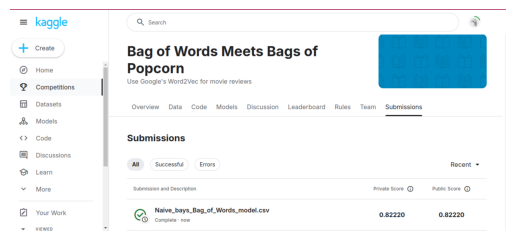

In [72]:
# Path to the image file
image_path = 'Kaggle.png'

# Load the image
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.show()

In [ ]:
# The End